In [1]:
import cvxpy as cp
import numpy as np


In [2]:
n = 5
x = cp.Variable()
v = [2*x + i for i in range(n)]  # vector of expressions

t = cp.Variable()
constraints = [t <= vi for vi in v]
constraints += [x >= 0]  # x must be non-negative
constraints += [x <= 10]  # x must be less than or equal to 10
objective = cp.Maximize(t)
prob = cp.Problem(objective, constraints)
prob.solve()

print("Optimal t (min value):", t.value)
print("Optimal x:", x.value)

Optimal t (min value): 19.999999996126466
Optimal x: 9.999999997700927


Optimal x: 2.0000
Maximum of minimum value t: 1.0000


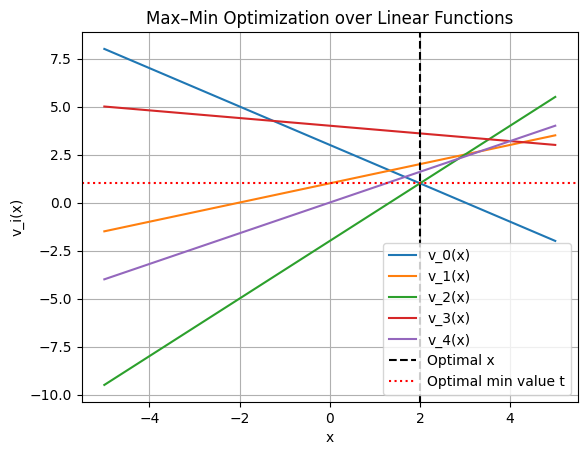

In [3]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Define variable
x = cp.Variable()
t = cp.Variable()  # auxiliary variable representing min of v_i

# Define different slopes and intercepts
a = np.array([-1, 0.5, 1.5, -0.2, 0.8])
b = np.array([3, 1, -2, 4, 0])

# Create expressions v_i = a_i * x + b_i
v = [a[i] * x + b[i] for i in range(len(a))]

# Constraints: t <= each v_i
constraints = [t <= vi for vi in v]
constraints += [x >= -5, x <= 5]  # bounding x

# Maximize the minimum of all v_i(x)
objective = cp.Maximize(t)
prob = cp.Problem(objective, constraints)
prob.solve()

# Print result
print(f"Optimal x: {x.value:.4f}")
print(f"Maximum of minimum value t: {t.value:.4f}")

# Optional: plot for visualization
x_vals = np.linspace(-5, 5, 200)
for i in range(len(a)):
    plt.plot(x_vals, a[i] * x_vals + b[i], label=f"v_{i}(x)")

plt.axvline(x.value, color='k', linestyle='--', label='Optimal x')
plt.axhline(t.value, color='r', linestyle=':', label='Optimal min value t')
plt.legend()
plt.title("Max–Min Optimization over Linear Functions")
plt.xlabel("x")
plt.ylabel("v_i(x)")
plt.grid(True)
plt.show()


In [4]:
# Okay lets try and set up a simple example with the BH

import jax.numpy as jnp

# Lets say there are 5 different areas that have five different demands
Demand = np.array([4, 6, 25, 10, 6]) # The demand for each area

# Time
time_slot = 0.1 # 0.1 seconds
time_window = 10 # 10 seconds
number_of_time_slots = int(time_window / time_slot) # 100 time slots

# Beams
number_of_beams = 2

# Rate per beam
rate_per_beam = 50 # 40 Mbps

t = cp.Variable()
x = cp.Variable((number_of_time_slots, Demand.shape[0]), boolean=True) # x is a matrix of size (number_of_time_slots, number_of_areas)

# Setup expressions for the rate per area
expressions = [rate_per_beam/(Demand[i]*number_of_time_slots)*cp.sum(x[:, i])  for i in range(Demand.shape[0])]


constraints = [t <= expression for expression in expressions] # t is less than or equal to the rate per area

constraints += [cp.sum(x, axis=1) <= number_of_beams]

print(constraints)

# The rates that can be covered are 40 
Objective = cp.Maximize(t)

prob = cp.Problem(objective, constraints)

prob.solve(solver=cp.ECOS_BB)

if x.value is not None:
    schedule = jnp.round(x.value).astype(int)
else:
    print("No feasible solution found.")

[Inequality(Variable((), var187)), Inequality(Variable((), var187)), Inequality(Variable((), var187)), Inequality(Variable((), var187)), Inequality(Variable((), var187)), Inequality(Expression(AFFINE, NONNEGATIVE, (100,)))]
No feasible solution found.


In [5]:
prob.status, prob.value

('infeasible', -inf)

In [6]:
plt.imshow(schedule, cmap='gray', aspect='auto', interpolation='none')

NameError: name 'schedule' is not defined

In [11]:
import cvxpy as cp
import numpy as np
import jax.numpy as jnp

# Parameters
Demand = np.array([7, 6, 6, 6, 6])
time_slot = 0.1
time_window = 10
T = int(time_window / time_slot)
B = 3
rate = 50

# Variables
t = cp.Variable()
x = cp.Variable((T, Demand.size), boolean=True)  # x is a matrix of size (T, number_of_areas)

# Build constraints
constraints = []

# 1) Fairness: t <= (total data to area i) / (Demand[i])
for i in range(Demand.size):
    total_data_i = rate  * cp.sum(x[:, i])
    constraints.append(t <= total_data_i / (Demand[i]*T))

# 2) Beam‐count per slot (expanded as scalars)
for tt in range(T):
    constraints.append(cp.sum(x[tt, :]) <= B)

# 3) (Optionally) force t >= 0 so it doesn’t go negative
constraints.append(t >= 0)
constraints.append(t <= 1)  # Optional upper bound for t

# Problem
objective = cp.Maximize(t)
prob = cp.Problem(objective, constraints)

# Solve with ECOS_BB
prob.solve(solver=cp.ECOS_BB)

print("status:", prob.status)
print("objective (t):", prob.value)
if x.value is not None:
    schedule = jnp.round(x.value).astype(int)
    print("schedule shape:", schedule.shape)
else:
    print("No solution (x.value is None).")


status: optimal_inaccurate
objective (t): 3.727638682373399e-13
schedule shape: (100, 5)


c:\Users\David\non_sync_documents\P10masters\P10masters\.venv\lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


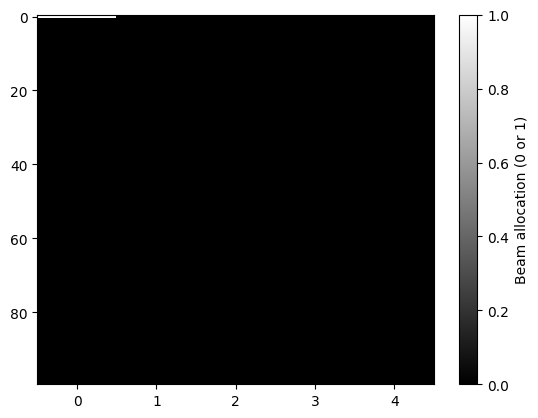

In [12]:
plt.imshow(schedule, cmap='gray', aspect='auto', interpolation='none')
plt.colorbar(label='Beam allocation (0 or 1)')

In [ ]:
# Calculate the C/D for each area
C_D = np.zeros(Demand.shape[0])
for i in range(Demand.shape[0]):
    C_D[i] = rate * np.sum(schedule[:, i]) / (Demand[i]*T)
print("C/D for each area:", C_D)

C/D for each area: [0.         0.         4.69999981 5.         0.        ]


In [ ]:
# Latency calculation
# Check for distance between ones in x
latency = np.zeros(Demand.shape[0])
for i in range(Demand.shape[0]):
    indices = np.where(schedule[:, i] == 1)[0]
    if len(indices) > 0:
        latency[i] = np.max(indices) - np.min(indices)  # max - min gives the duration of the beam allocation
    else:
        latency[i] = 0  # No allocation, no latency

print("Latency for each area:", latency)

Latency for each area: [98. 97. 96. 94. 97.]


In [ ]:
import cvxpy as cp
import numpy as np

Demand = np.array([4, 6, 10, 10, 6])
time_slot = 0.1
time_window = 10
T = int(time_window / time_slot)
B = 3
rate = 50

t = cp.Variable()
x = cp.Variable((T, Demand.size), boolean=True)

constraints = []
for i in range(Demand.size):
    data_needed = Demand[i] * T * time_slot
    data_allocated = rate * time_slot * cp.sum(x[:, i])
    constraints.append(t <= data_allocated / data_needed)

for tt in range(T):
    constraints.append(cp.sum(x[tt, :]) <= B)

constraints += [t >= 0, t <= 1]

objective = cp.Maximize(t)
prob = cp.Problem(objective, constraints)

# Solve with GLPK_MI
prob.solve(solver=cp.GLPK_MI)

print("status:", prob.status)
print("objective (t):", prob.value)


SolverError: The solver GLPK_MI is not installed.

Status: Optimal
Optimal t: 0.54
Selected (i, k) pairs where x[i][k] = 1:


Text(0.5, 1.0, 'Beam Allocation Schedule')

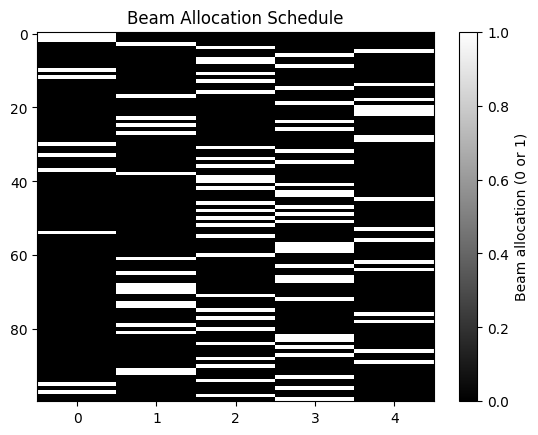

In [12]:
import pulp
import numpy as np

Demand = np.array([4, 6, 10, 10, 6])
time_slot = 0.1
time_window = 10
T = int(time_window / time_slot)
B = 1
rate = 50

# Define your sets I and K
I = np.arange(T) # list of items i (e.g., range(1, n_items+1))
K = np.arange(5) # list of categories k (e.g., range(1, n_categories+1))

# Define parameters
R =  20 # dictionary mapping each k to its R_k value, e.g., R = {1: 10, 2: 15, ...}
D = {0 : 4, 1 : 6, 2 : 10, 3 : 10, 4 : 6}  # dictionary mapping each k to its D_k value, e.g., D = {1: 2, 2: 3, ...}
M = T    # scalar M (e.g., M = 5)

# Create the model
model = pulp.LpProblem("MaxMinOptimization", pulp.LpMaximize)

# Decision variables
t = pulp.LpVariable("t", lowBound=0, cat='Continuous')
x = pulp.LpVariable.dicts("x", (I, K), cat='Binary')

# Objective
model += t

# Constraints: t <= (R_k / (M * D_k)) * sum_i x_{i,k}
for k in K:
    model += t <= (R / (M * D[k])) * pulp.lpSum(x[i][k] for i in I)

for i in I:
    #print(i)
    model += B >= pulp.lpSum(x[i][k] for k in K)   # Beam-count constraint

# (Optional) Additional constraints, e.g., limit total selections:
# model += pulp.lpSum(x[i][k] for i in I for k in K) <= some_limit

# Solve
model.solve(pulp.PULP_CBC_CMD(msg=1, maxNodes=1000))

# Results
print("Status:", pulp.LpStatus[model.status])
print("Optimal t:", pulp.value(t))
print("Selected (i, k) pairs where x[i][k] = 1:")

schedule = np.zeros((T, len(K)))
for i in I:
    for k in K:
        if pulp.value(x[i][k]) == 1:
            schedule[i][k] = 1

import matplotlib.pyplot as plt
plt.imshow(schedule, cmap='gray', aspect='auto', interpolation='none')
plt.colorbar(label='Beam allocation (0 or 1)')
plt.title("Beam Allocation Schedule")

In [14]:
# Calculate the C/D for each area
C_D = np.zeros(Demand.shape[0])
for i in range(Demand.shape[0]):
    C_D[i] = 20 * np.sum(schedule[:, i]) / (Demand[i]*T)
print("C/D for each area:", C_D)

C/D for each area: [0.55       0.56666667 0.54       0.56       0.56666667]
